# Segmentacja obrazów
Opracowanie: A.Florkowska

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as nd
from skimage import color, io
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage import measure
from skimage import feature
import scipy.signal as signal
import time
import queue
from IPython.display import Image

# Segmentacja 
To proces podziału obrazu na mniejsze obszary (= segmenty), które są w pewien sposób jednorodne lub mają wspólne cechy. Dzięki temu możliwe jest wyodrębnienie i wizualizację poszczególnych struktur (= fragmentów, obiektów) obrazu, umożliwiając jednocześnie eliminację elementów niepożądanych np. szumów.

Można wyróżnić kilka rodzajów segmentacji:
- lokalna / globalna
  * lokalna - koncentruje się na mniejszych obszarach obrazu podczas analizy lokalnych cechy i różnic między pikselami / wokselsami lub ich grupami, w ten sposób tworzy lokalne kryteria segmentacji
  * globalna - polega na analizie całego obrazu stosując jednolite kryteria segmentacji na wszystkich pikselach / wokselach
- twarda / miękka
  * twarda - zwraca informacje o przynależności piksela do konkretnego podzbioru i jest kategoryczna, czyli żaden piksel / woksel nie należy równocześnie do dwóch podzbiorów (są one rozłączne)
  * miękka - określa prawdopodobieństwo przynależności do określonego podzbioru
- pojedynczoetykietowa / wieloetykietowa
  * pojedynczoetykietowa - każdy piksel / woksel przypisany jest do dokładnie jednej klasy
  * wieloetykietowa - każdy piksel / woksel może być przypisany do wielu klas jednocześnie np. gdy obiekty nachodzą na siebie lub obiekt posiada kilka właściwości, które są analizowane

Główne techniki segmentacji obrazu:

- na podstawie progowania
- oparte o krawędzie
- oparta o regiony
- z wykorzystaniem technik uczenia maszynowego i głębokiego uczenia

Zastosowanie segmentacji można odnaleźć w wielu dziedzinach, między innymi:

- medycyna: segmentacje danych z MRI czy CT do identyfikacji różnych tkanek, organów czy zmian patologicznych
- automatyka i robotyka: do nawigacji, wykrywania przeszkód czy rozpoznawania obiektów
- przetwarzanie obrazów satelitarnych: do analizy terenu, wykrywania zmian środowiskowych

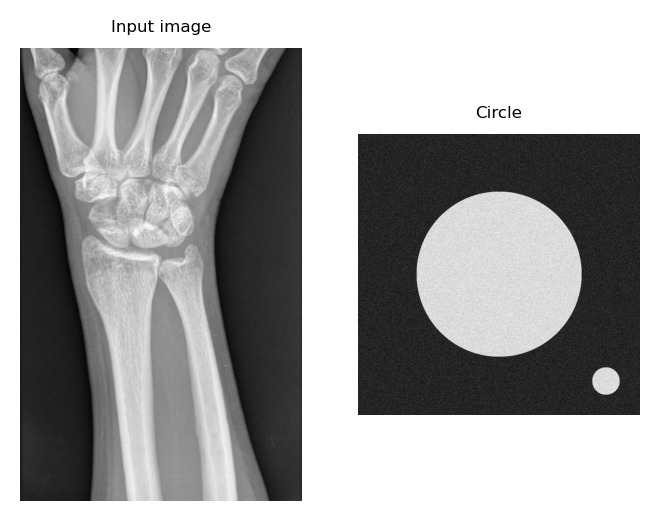

In [12]:
def generate_circle(y_size, x_size, x_origin, y_origin, radius):
    image = np.zeros((y_size, x_size))
    x_grid, y_grid = np.meshgrid(np.arange(x_size), np.arange(y_size))
    indices = np.square((x_grid - x_origin)) + np.square((y_grid-y_origin)) < radius*radius
    image[indices] = 1
    return image

normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
image = io.imread(".././images/example1.png")
image = image[:,:,0:3]
image = color.rgb2gray(image)
image = normalize(image)

y_size = 1024
x_size = 1024
circle = generate_circle(y_size, x_size, 512, 512, 300)
circle_2 = generate_circle(y_size, x_size, 900, 900, 50)
circle = np.logical_or(circle, circle_2)
circle = circle + (np.random.random((y_size, x_size))-0.5)*0.4
circle = normalize(circle)

plt.figure(figsize=(4, 6), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 2, 2)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.title("Circle", fontsize=6)
plt.show()

# Progowanie
Najprostsza forma segmentacji, która polega na wyborze wartości progu i klasyfikacji wszystkich pikseli obrazu na podstawie tego progu. Piksele powyżej progu mogą być klasyfikowane jako obiekt, a poniżej jako tło. Czasami ustalane są dwa progi, wtedy co to między wartościami progu traktowane jest jako obiekt, reszta jako tło.

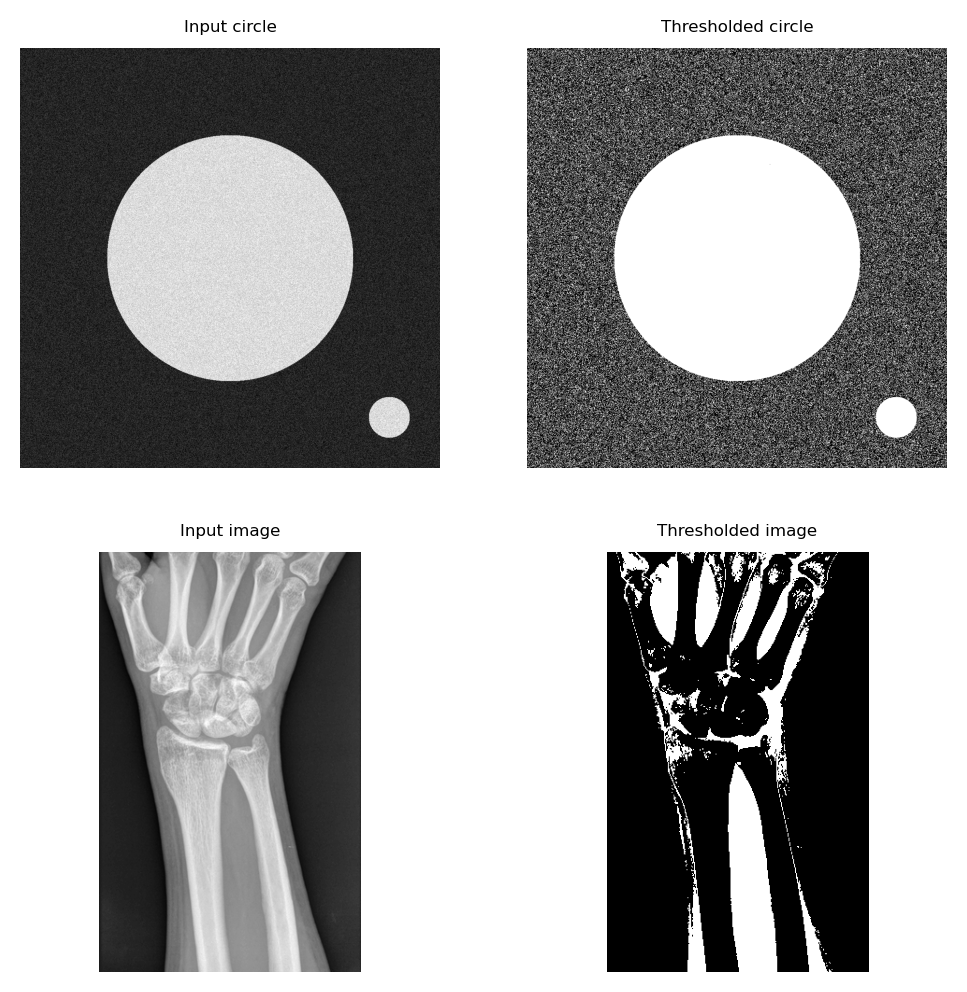

In [25]:
def image_threshold(image, lower, upper):
    return np.logical_and(image > lower, image < upper)

circle_thresholded = image_threshold(circle, 0.2, 1)
image_thresholded = image_threshold(image, 0.48, 0.64)

plt.figure(figsize=(6, 6), dpi=200)
plt.subplot(2, 2, 1)
plt.imshow(circle, cmap='gray')
plt.title("Input circle", fontsize=6)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(circle_thresholded, cmap='gray')
plt.title("Thresholded circle", fontsize=6)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(image, cmap='gray')
plt.title("Input image", fontsize=6)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(image_thresholded, cmap='gray')
plt.title("Thresholded image", fontsize=6)
plt.axis('off')
plt.show()

# Segmentacja oparta o regiony 
Polega na grupowaniu pikseli w regiony na podstawie podobnych wartości. Najczęściej stosowane metody to rośnięcie regionów (region growing) i łączenie regionów (region merging).

Algorytm rozrostu obszarów można traktować jako ulepszone progowanie, z dodaną analizą położenia (sąsiedztwa). Innymi słowy, oprócz spełnienia kryterium odpowiedniej intensywności, aby piksel został zaliczonny do obiektu musi sąsiadować z odpowiednimi pikselami (wcześniej do niego zaliczonymi).

Metoda ta wymaga:
- zdefiniowania początkowego obiektu - punktu startowy (seed point), który się rozrasta
- kryterium dołączania nowych punktów

Główne 2 typy algorytmów rozrostu regionów:
- lokalny - możliwe jest zdefiniowanie kilku progów, tym samym wyodrębnienia kilku typów obiektów
- globalny - używa jednego progu podziału dla wszystkich pikseli

# Globalny rozrost obszarów - algorytm

In [26]:
def region_growing_global(image, seed, bottom_threshold, upper_threshold):
  img_extraction= image_threshold(image, image[seed] - bottom_threshold, image[seed] + upper_threshold )
  img_extraction = nd.binary_dilation(img_extraction , np.ones((3, 3)))   
  all_labels= measure.label(img_extraction) 
  seed_label = all_labels[seed] 
  new_img = np.equal(all_labels, seed_label ) 
  return all_labels, new_img

# Lokalny rozrost obszarów - algorytm

In [27]:
# breath-first search - queue / deep-first search - stack
def get8neighbors(seed, image):
  neighbors = []
  start_seed = (seed[0]-1,seed[1]-1)
  n=3
  for i in range(0,n):
    for j in range(0,n):
      neighbors.append( (start_seed[0]+i,start_seed[1]+j) )
  neighbors = neighbors[0:4] + neighbors[5:9]
  if(seed[0]==0):
    neighbors= list(filter(lambda coord: coord[0] >=0, neighbors))
    neighbors= list(filter(lambda coord: coord[1] >=0, neighbors))
  if(seed[1]==0):
    neighbors= list(filter(lambda coord: coord[0] >=0, neighbors))
    neighbors= list(filter(lambda coord: coord[1] >=0, neighbors))
  if(seed[0]==image.shape[0]-1):
    neighbors=list(filter(lambda coord: coord[0] <image.shape[0], neighbors))
    neighbors= list(filter(lambda coord: coord[1] <image.shape[1], neighbors))
  if(seed[1]==image.shape[1]-1):
    neighbors=list(filter(lambda coord: coord[0] <image.shape[0], neighbors))
    neighbors= list(filter(lambda coord: coord[1] <image.shape[1], neighbors))
  return neighbors

def region_growing_local(image, seed, bottom_threshold, upper_threshold):
  seed_points = queue.Queue()
  new_image = np.zeros_like(image, dtype=bool)
  new_image[seed] = True

  seed_points.put(seed)
  visited_seeds = set() 
  while(seed_points.qsize() > 0):
    current_seed = seed_points.get()
    for coord in get8neighbors(current_seed, image): 
      #print("Obecny analizowany główny punkt",coord) 
      #print("Wartosci",image[coord],image[current_seed] - bottom_threshold, image[current_seed] + upper_threshold ) 
      condition = image_threshold(image[coord], image[current_seed] - bottom_threshold, image[current_seed] + upper_threshold )
      #print("warunek", condition)
      if condition: 
        if not coord in visited_seeds: 
          seed_points.put(coord)
          new_image[coord] = True
        visited_seeds.add(coord)
  return new_image



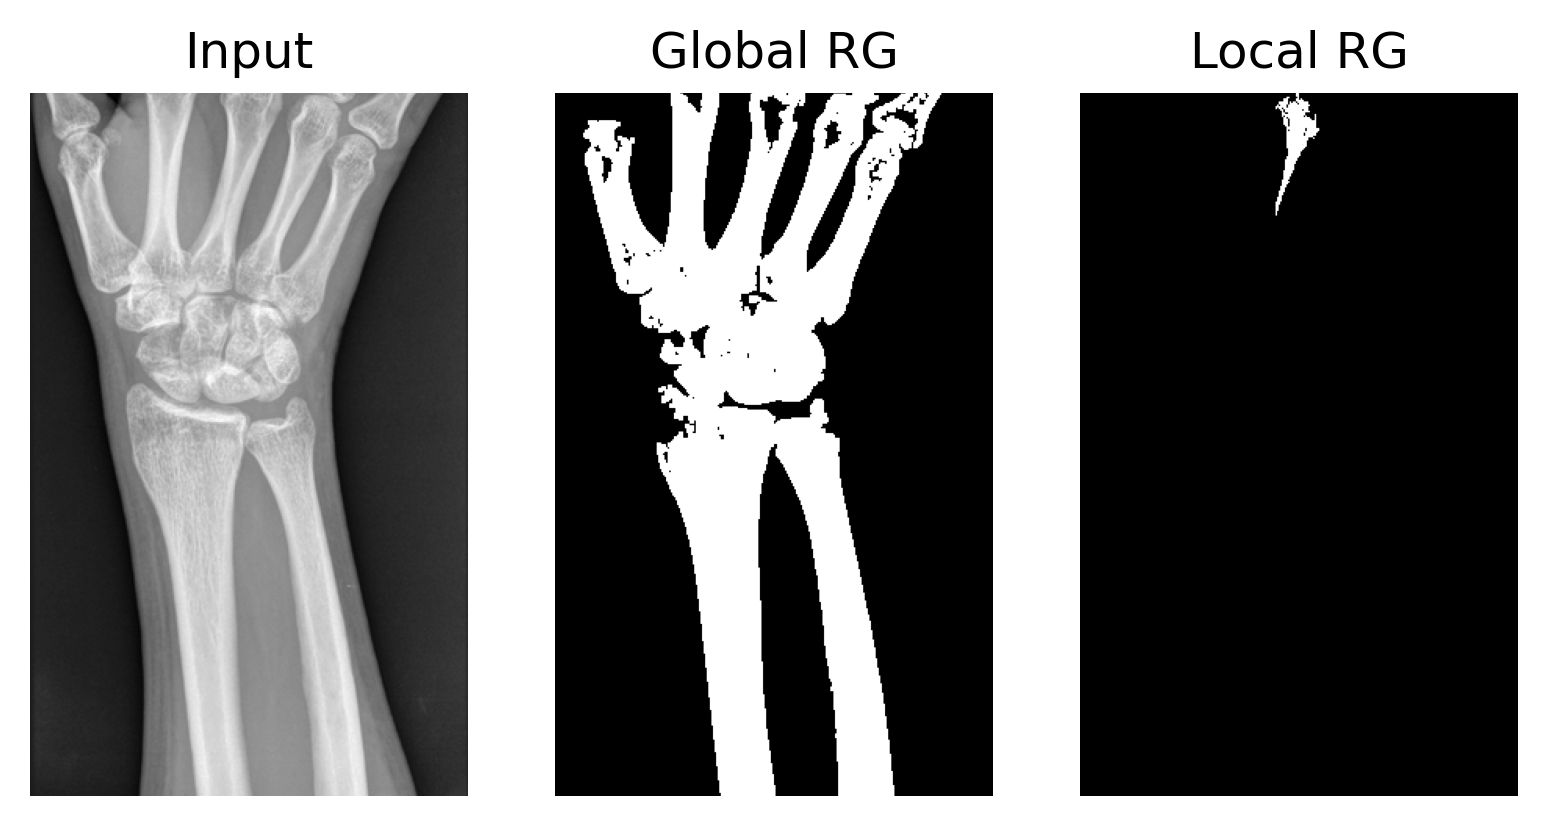

Global region growing - time:  0.030672311782836914
Local region growing - time:  13.255784034729004


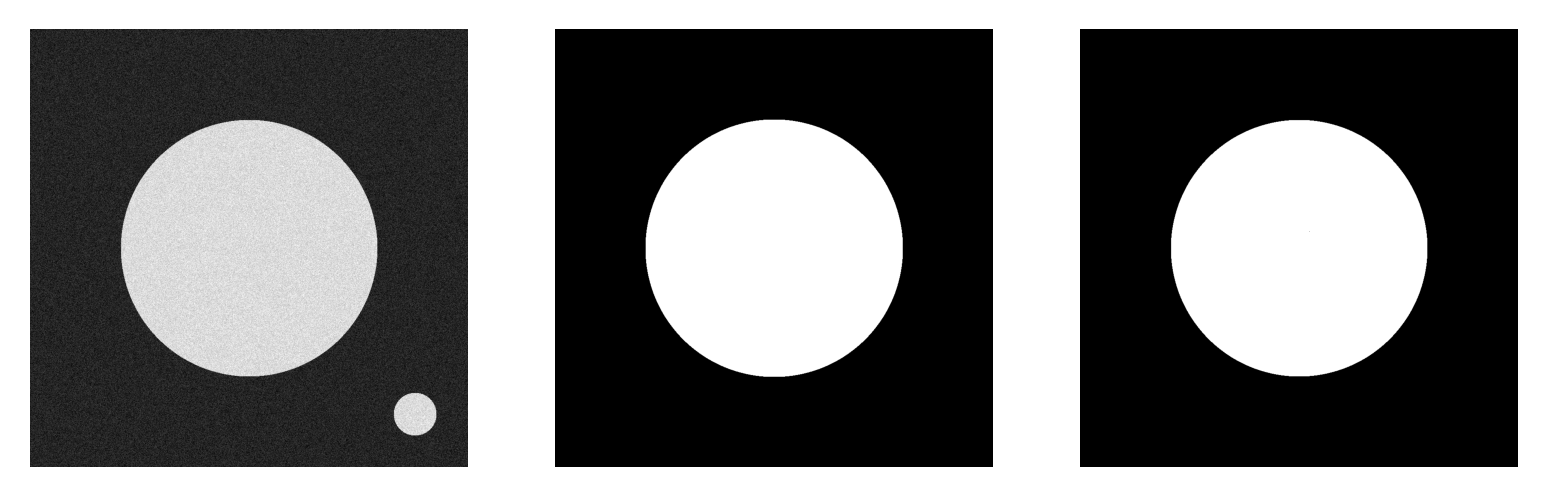

In [30]:
blobs_result, new_img_global = region_growing_global(image, (50,130), 0.1, 0.2  )
new_img_local = region_growing_local(image, (50,130), 0.017, 0.017 )

plt.figure(dpi=300)
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Input")
plt.subplot(1, 3, 2)
plt.imshow(new_img_global, cmap='gray')
plt.axis('off')
plt.title("Global RG")
plt.subplot(1, 3, 3)
plt.imshow(new_img_local, cmap='gray')
plt.axis('off')
plt.title("Local RG")
plt.show()


center = (int(circle.shape[0] / 2) - 1, int(circle.shape[1] / 2) - 1)
start = time.time()
blobs_result, circle_region_global = region_growing_global(circle, center, 0.2, 0.2)
end = time.time()
print("Global region growing - time: ", end - start )
start = time.time()
circle_region_local = region_growing_local(circle, center, 0.2, 0.2)
end = time.time()
print("Local region growing - time: ", end - start )

plt.figure(dpi=300)
plt.subplot(1, 3, 1)
plt.imshow(circle, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(circle_region_global, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(circle_region_local, cmap='gray')
plt.axis('off')

plt.show()

# Segmentacja oparta o krawędzie
Technika ta wykrywa krawędzie na obrazie poprzez wykrywanie miejsc, gdzie następuje nagła zmiana jasności, i jednocześnie usuwa pozostałe fragmenty obrazu. Krawędzie te mogą następnie być użyte do oddzielenia różnych obiektów na obrazie.

Do tego celu można wykorzystać poznane już wcześniej techniki takie jak: metody gradientowe, maski Prewitta czy Sobela, Laplasjan czy algorytm Canny'ego.

In [ ]:
# Przykłady masek i gradientów

# Algorytm Canny'ego
Wieloetapowy algorytm służący do wykrywania krawędzi. 

1. Filtracja obrazu filtrem Gaussa w celu usunięcia drobnych szumów poprzez rozmycie obrazu wejściowego
2. Obliczenie pochodnych kierunkowych, czyli gradientu, korzystając z operatorów kierunkowych np. operatora Sobela. Szukanie natężenia gradientu obrazu.
3. Określenie kierunku krawędzi na obrazie poprzez obliczenie kąta gradientu. Kąt detekcji krawędzi został zawężony do 4 przypadków reprezentujących: pion, poziom i dwie przekątne (0,45,90 i 135 stopni)
4. Progowanie histogramu (z histerezą), czyli wygaszanie pikseli / wokseli, które nie spełniają warunku - nie mają maksymalnej wartości natężenia. Dzięki temu krawędzie będą odpowiednio wyrażne oraz zostanie zredukowany efekt rozmycia krawędzi. 

Można użyć również operatora Prewitta, jednak znalezione krawędzie będą nieco grubsze, jaśniejsze i bardziej wyraźne. Nie ma to jednak dużego znaczenia na jakość przetwarzania.

In [ ]:
# Algorytm Cannyego